In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from keras.models import Model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os

In [69]:
def load_model(filename, verbose=False):
    json_file = open(filename + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(filename + ".h5")
    if verbose:
        print("The following model " + filename + " has been loaded")
    return loaded_model

## Load data

In [70]:
DATA_FOLDER = "./data/"

In [71]:
df_training = pd.read_parquet(DATA_FOLDER + "training.parquet")

In [72]:
df_public_test = pd.read_parquet(DATA_FOLDER + "public_test.parquet")

In [73]:
df_private_test = pd.read_parquet(DATA_FOLDER + "private_test.parquet")

## Process data

In [74]:
x_train = df_training.values[:,1:]
y_train = df_training.values[:,0]
x_test = df_public_test.values[:,1:]
y_test = df_public_test.values[:,0]
x_private_test = df_private_test.values[:,1:]
y_private_test = df_private_test.values[:,0]

In [75]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_private_test = x_private_test.reshape(-1, 48, 48, 1)

In [76]:
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.
x_private_test = x_private_test.astype("float32")/255.

In [77]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_private_test = to_categorical(y_private_test)

## Test model

In [78]:
filename = "trained_models/conv_nn_model"

In [79]:
model = load_model(filename)

In [80]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [81]:
def plot_confusion_matrix(model, x, y):
    def argmaxer(arr):
        p=[]
        for pred in arr:
            p.append(np.argmax(pred))
        return p

    predictions = model.predict(x)
    a = argmaxer(predictions)
    b = argmaxer(y)
    lables = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    cm = confusion_matrix(b,a, labels=None)
    df = pd.DataFrame(cm,index = [i for i in lables],
                  columns = [i for i in lables])
    plt.figure(figsize = (16,7))
    sn.heatmap(df, annot=True, fmt="d")
    

In [82]:
def evaluate(model, x_train, y_train, x_test, y_test, x_private_test, y_private_test):
    
    loss, acc = model.evaluate(x_train, y_train, batch_size=1000, verbose=0)
    print("Train")
    print("loss: " + "{0:.2f}".format(loss) + " acc: " + "{0:.2f}".format(acc))
    
    loss, acc = model.evaluate(x_test, y_test, batch_size=1000, verbose=0)
    print("Test")
    print("loss: " + "{0:.2f}".format(loss) + " acc: " + "{0:.2f}".format(acc))
    
    
    loss, acc = model.evaluate(x_private_test, y_private_test, batch_size=1000, verbose=0)
    print("Private test")
    print("loss: " + "{0:.2f}".format(loss) + " acc: " + "{0:.2f}".format(acc))
    

In [83]:
def display_activation(model, col_size, row_size, act_index): 
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(test_img.reshape(1,48,48,1))
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size): 
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [84]:
evaluate(model, x_train, y_train, x_test, y_test, x_private_test, y_private_test)

Train
loss: 0.86 acc: 0.68
Test
loss: 1.05 acc: 0.61
Private test
loss: 1.00 acc: 0.63


In [ ]:
plot_confusion_matrix(model, x_train, y_train)

In [ ]:
plot_confusion_matrix(model, x_test, y_test)

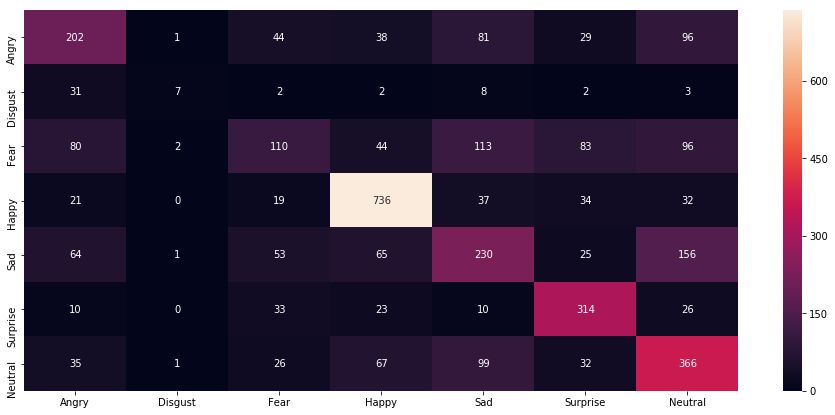

In [97]:
plot_confusion_matrix(model, x_private_test,y_private_test)

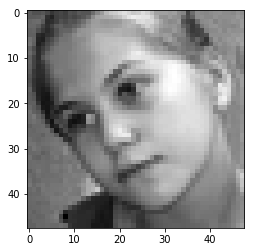

In [66]:
test_img = x_private_test[6]
plt.imshow(test_img.reshape(48, 48), cmap='gray')
plt.show()

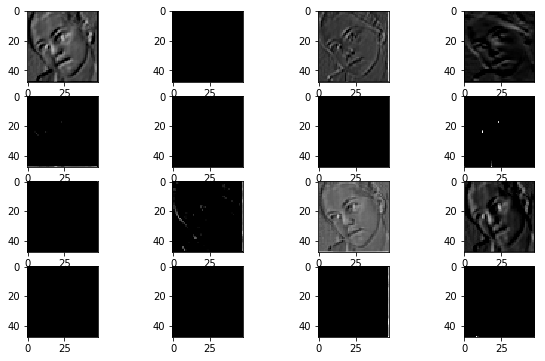

In [51]:
display_activation(model, 4, 4, 0)

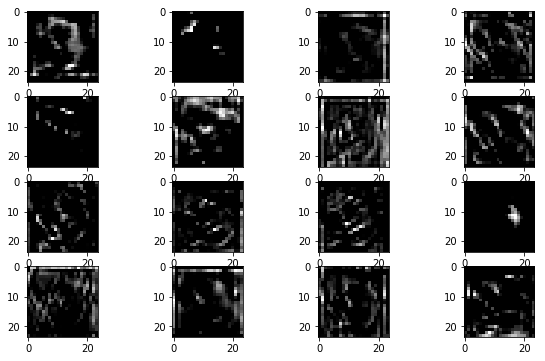

In [67]:
display_activation(model, 4, 4, 3)

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)